In [6]:
import os
import rail
import qp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from rail.estimation.algos.NZDir import Inform_NZDir, NZDir
from rail.core.data import TableHandle, QPHandle
from rail.core.stage import RailStage

In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [3]:
# Load up the example healpix 9816 data and stick in the DataStore
from rail.core.utils import RAILDIR
trainFile = os.path.join(RAILDIR, 'rail/examples/testdata/test_dc2_training_9816.hdf5')
testFile = os.path.join(RAILDIR, 'rail/examples/testdata/test_dc2_validation_9816.hdf5')
training_data = DS.read_file("training_data", TableHandle, trainFile)
test_data = DS.read_file("test_data", TableHandle, testFile)

In [4]:
inf_nz = Inform_NZDir.make_stage(n_neigh=8, hdf5_groupname="photometry", model="nzdir_model.pkl")
inf_nz.inform(training_data)
nzd = NZDir.make_stage(leafsize=20, zmin=0.0, zmax=3.0, nzbins=31, model="NZDir_model.pkl", hdf5_groupname='photometry',
                       output='NZDir_samples.hdf5', single_NZ='NZDir_NZ.hdf5')

Inserting handle into data store.  model: inprogress_nzdir_model.pkl, Inform_NZDir


In [5]:
# I don't know why it is necessary to execute this estimate once before saving everything to a pipeline
nzd_res = nzd.estimate(test_data)

Inserting handle into data store.  output: inprogress_NZDir_samples.hdf5, NZDir
Inserting handle into data store.  single_NZ: inprogress_NZDir_NZ.hdf5, NZDir


Creating a pipeline with 2 process

In [6]:
import ceci
pipe = ceci.Pipeline.interactive()
stages = [inf_nz,nzd]
for stage in stages:
    pipe.add_stage(stage)
pipe.stage_execution_config['NZDir'].nprocess=2

In [7]:
pipe.initialize(dict(training_data=trainFile, test_data=testFile) , dict(output_dir='.', log_dir='.', resume=False), None)

(({'Inform_NZDir': <Job Inform_NZDir>, 'NZDir': <Job NZDir>},
   <rail.estimation.algos.NZDir.NZDir at 0x7f657c6860a0>]),
 {'output_dir': '.', 'log_dir': '.', 'resume': False})

In [8]:
pipe.save('nzdir.yml')

Once the pipeline is saved, we execute it

In [2]:
import ceci

In [3]:
pr = ceci.Pipeline.read('nzdir.yml')

Inserting handle into data store.  model: ./nzdir_model.pkl, NZDir


In [4]:
pr.run()


Executing Inform_NZDir
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.estimation.algos.NZDir.Inform_NZDir   --input=/home/josue/cosmologia/photoz/RAIL/src/rail/examples/testdata/test_dc2_training_9816.hdf5   --config=nzdir_config.yml   --model=./nzdir_model.pkl 
Output writing to ./Inform_NZDir.out

Job Inform_NZDir has completed successfully!

Executing NZDir
Command is:
OMP_NUM_THREADS=1  mpirun -n 2 python3 -m ceci rail.estimation.algos.NZDir.NZDir   --model=./nzdir_model.pkl   --input=/home/josue/cosmologia/photoz/RAIL/src/rail/examples/testdata/test_dc2_validation_9816.hdf5   --config=nzdir_config.yml   --output=./NZDir_samples.hdf5   --single_NZ=./NZDir_NZ.hdf5 --mpi
Output writing to ./NZDir.out

Job NZDir has completed successfully!


0

Reading the output

In [11]:
nzd_ens = qp.read('NZDir_samples.hdf5')
nzdir_nz = qp.read("NZDir_NZ.hdf5")

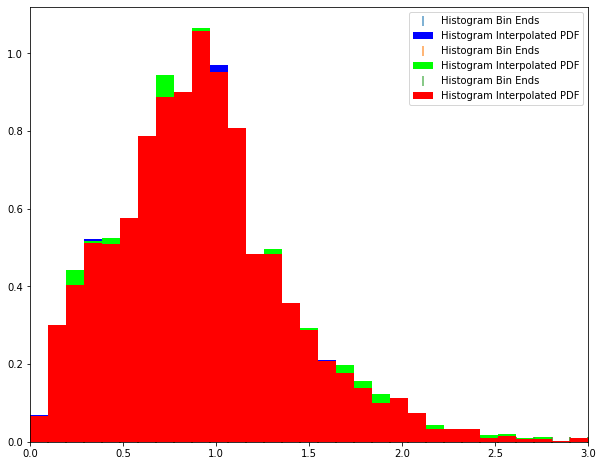

In [14]:
fig, axs = plt.subplots(figsize=(10,8))
nzdir_nz[0].plot_native(axes=axs, fc = [0, 0, 1, 0.01])
nzd_ens[1].plot_native(axes=axs, fc = [0, 1, 0, 0.01])
nzd_ens[4].plot_native(axes=axs, fc = [1, 0, 0, 0.01])
axs.set_xlim(0,3)
axs.legend()